# GeoNet FDSN webservice with rFDSN to do Date Select

## Table of contents


###### Set up

######  Data select

######  Basic stats

######  Ploting data 

###### Saving data as csv

## Set up

    This tutorial assumes that you have R and basic knowledge of R. We will be using using a package called IRISSeismic (https://CRAN.R-project.org/package=IRISSeismic).

###### Install the IRISSemismic package

In [1]:
install.packages("IRISSeismic")

Warning message:
"unable to access index for repository http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/3.5:
  cannot open URL 'http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/3.5/PACKAGES'"

package 'IRISSeismic' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jlowe\AppData\Local\Temp\RtmpKGrgzC\downloaded_packages


    Note this code might tack some time to run but you only need to run this once.
    IRISSemismic has meny functions that may be usefull to see a list of them all with description run         library(help = "IRISSeismic")

###### Import the IRISSeimic library and set your urls to the same as below

In [2]:
library(IRISSeismic)
#Near real time
nrt <- new('IrisClient', site = 'https://service-nrt.geonet.org.nz')
#Archive
acr <- new('IrisClient', site = 'https://service.geonet.org.nz')

    GeoNet has two FDSN servers
    An archive server holds verified data starting 7days after collection
    A near real-time servers holds unverified data from the last 8 days

## Data Select

###### Set the start and end time of the data you want to select

In [3]:
starttime <- as.POSIXct("2016-11-13 11:00:00.000",tz="GMT")
endtime <- starttime + 900

    Note that time must be in UTC (Universtal Time Coordinated) which is 13 or 12 hours behind nzt(New Zealand Time) (depending on daylight savings time).
    In this case we are looking at the 2016 Kaikoura earthqake wich happend just after midnight on 14th of    Novermber. 
    There are online converters such as https://savvytime.com/converter/utc-to-nzst.
    You can add to times made in this way. You add to the time in number of seconds as done for endtime in above exmple where we are looking from 11am UTC to 11.15am UCT

###### Get data from servers by trying both nrt and arc severs

In [4]:
try(arc_data <- getDataselect(acr,"NZ", "THZ","*", "HHE",starttime ,endtime, ignoreEpoch=TRUE))
try(nrt_data <- getDataselect(nrt,"NZ", "THZ","*", "HHE",starttime ,endtime, ignoreEpoch=TRUE))

    The parameters are in the order network, station, location, channel, starttime, and endtime.
    The * say it will look for data with any location code.
    This code may take some time to run. Time taken to run depends on the size of data you have requested

###### Merge the data from the 2 servers

In [5]:
try(st <- arc_data)
try(st <- nrt_data)
try(tr <- nrt_data@traces[[1]])
try(acr_data@traces[[2]] <- tr)
try(st <- mergeTraces(arc_data))

    If the data is only from one server it will just rename it st
    If it come from both it will merge them and renmae it st

## Basic stats

###### Cheak basic things about the sensor

In [6]:
tr <- st@traces[[1]]#tack the trace out of the stream. in this case we only have one
print("stats:")
slot(tr, "stats")
print("Sensor type:")
slot(tr,"Sensor")
print("Instrument Sensitivity:")
slot(tr,"InstrumentSensitivity")
print("Sensitivity Frequency:")
slot(tr,"SensitivityFrequency")
print("Input Units:")
slot(tr,"InputUnits")

[1] "stats:"


Seismic Trace TraceHeader 
 Network:        NZ 
 Station:        THZ 
 Location:       10 
 Channel:        HHE 
 Quality:        D 
 calib:          1 
 npts:           90314 
 sampling rate:  100 
 delta:          0.01 
 starttime:      2016-11-13 10:59:58 
 endtime:        2016-11-13 11:15:01 
 latitude:       -41.76247 
 longitude:      172.9052 
 elevation:      747 
 depth:          0 
 azimuth:        90 
 dip:            0 
 processing:      

[1] "Sensor type:"


[1] "Broadband Seismometer"

[1] "Instrument Sensitivity:"


[1] 838860800

[1] "Sensitivity Frequency:"


[1] 1

[1] "Input Units:"


[1] "m/s"

    Due to the way IRISSeimsimic works each getDataselect call will only have one trace in it. 
    The station will need to be split into its trace to get this data.
    You can just run the code tr but this will also output the waveform data in the trace.
    

###### Cheek if the data has gaps. 

In [7]:
getGaps(st)

$gaps
[1] 0 0

$nsamples
[1] 0 0

    This data has no gaps.
    If the data dose then it will say how meny gaps there are and what size (in samples) they are.

###### Print out some basic stats

In [8]:
print("max data point:")
max(st)
print("mean of data:")
mean(st)
print("standard deviation of data:")
sd(st)
print("root mean square of data:")
rms(st)
print("root mean square variance of data:")
rmsVariance(st)

[1] "max data point:"


[1] 8708872

[1] "mean of data:"


[1] 6000.297

[1] "standard deviation of data:"


[1] 2395065

[1] "root mean square of data:"


[1] 2395059

[1] "root mean square variance of data:"


[1] 2395052

    Any of normal stats fuctions should work on this data as expected.
    To find out what these are are there description run library(help = "stats")

## Ploting data

###### Plot the data 

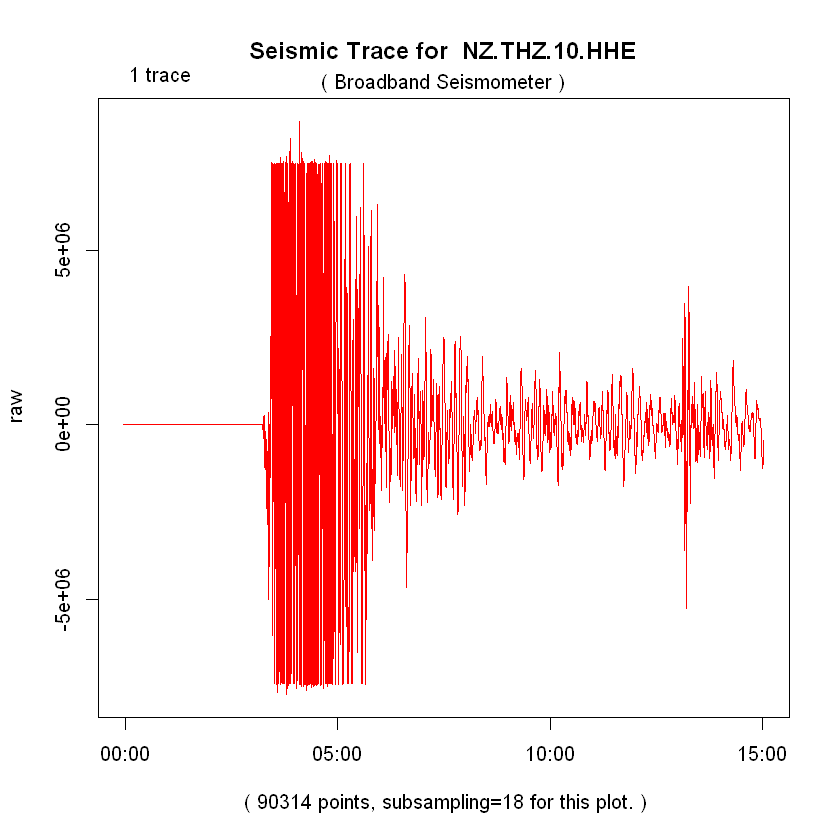

In [9]:
plot(st, col  = "red")

    Most parameter that you can give the plot fuction in R nomraly should work on this data set
    To find out what these are are there description go to https://www.rdocumentation.org/packages/graphics/versions/3.5.1/topics/plot
    Note that time is shown in minits on the x axis Where the point x=00:00 is 2016-11-13 11:00:00.000
    For data sets over longer time periods Time may be shown in hours or even days.
    If you right click on this plot in the notbook 
    

###### Slice the data to look at only earthquake

In [10]:
newstart <- as.POSIXct("2016-11-13 11:03:00.000",tz="GMT")
st_slice <- slice(st, newstart, endtime)

    The earthquake got to this station at about 11.03am UCT as seen in above graph so we don't need to look  at data before then
    The parameters of slice are in the order data, start time, end time 
    Note that time input must be in UTC. 

###### Plot this slice

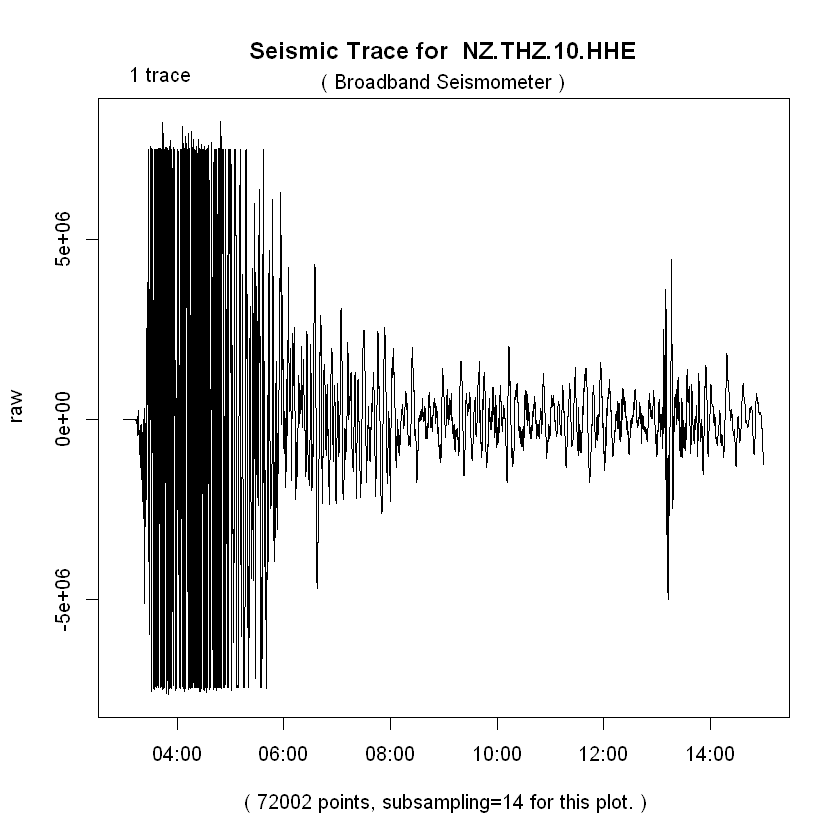

In [11]:
plot(st_slice)

    This plot should have about 3*60*10 less points above plot
    All things that can be done for plot(st) can be done on this plot

## Saving data as csv

In [12]:
tr <- st@traces[[1]]#tack the trace out of the stream. in this case we only have one
raw_data <- slot(tr,"data")
save(raw_data, file = "raw_data.csv", ascii = TRUE)

    This code gaps the trace from st, then gets the waveform data from the trace, and finaly saves it as the file raw_data.csv
    The file will be save in the same folder as this code is run from. 

IRISSeismic has alot of fuction that could be usefull. Documentation of them with exampls can be found at https://cran.r-project.org/web/packages/IRISSeismic/IRISSeismic.pdf